## Build classifier
Here we will build a simple NN classifier. The amount of data is quite small, so this won't require a GPU. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path

In [2]:
import os
import json

In [4]:
data_dir = os.path.abspath(r'./')
test_data_loc = os.path.join(data_dir,'test embeddings.json')
dev_data_loc = os.path.join(data_dir,'dev embeddings.json')
train_data_loc = os.path.join(data_dir,'train embeddings.json')

In [5]:
test = pd.read_csv(os.path.join(data_dir,'test.csv'), dtype=str)
train = pd.read_csv(os.path.join(data_dir,'train.csv'), dtype=str)
dev = pd.read_csv(os.path.join(data_dir,'dev.csv'), dtype=str)
train.shape, test.shape, dev.shape
print(train.shape)

(50087, 14)


In [6]:
with open(test_data_loc,'r') as f:
    test_embeddings = json.load(f)
with open(train_data_loc,'r') as f:
    train_embeddings  = json.load(f)
with open(dev_data_loc,'r') as f:
    dev_embeddings  = json.load(f)
len(train_embeddings), len(test_embeddings), len(dev_embeddings)

(50086, 10733, 10733)

In [7]:
train.columns

Index(['Unnamed: 0', 'Topic', 'TopicScore', 'PaperId', 'Title', 'Abstract',
       'DOI', 'Year', 'OnlineDate', 'Publisher', 'Journal', 'tcm',
       'title_lang', 'abs_lang'],
      dtype='object')

In [8]:
train = train.drop_duplicates(subset=['PaperId'], keep = 'first')
test = test.drop_duplicates(subset=['PaperId'], keep = 'first')
dev = dev.drop_duplicates(subset=['PaperId'], keep = 'first')

dev = dev[dev['PaperId'].isin(dev_embeddings)]
test = test[test['PaperId'].isin(test_embeddings)]
train = train[train['PaperId'].isin(train_embeddings)]

We need to combine the train and dev datasets to train the model.

In [9]:
import numpy as np
y_train = np.array([float(x) for x in train['tcm'].values]).T
x_train = np.array([train_embeddings[PaperId] for PaperId in train.PaperId.tolist()])
y_dev = np.array([float(x) for x in dev['tcm'].values]).T
x_dev = np.array([dev_embeddings[PaperId] for PaperId in dev.PaperId.tolist()])
np.shape(y_train), np.shape(x_train),np.shape(y_dev), np.shape(x_dev)

((50086,), (50086, 768), (10733,), (10733, 768))

In [10]:
y_test = np.array([float(x) for x in test['tcm'].values]).T
x_test = np.array([test_embeddings[PaperId] for PaperId in test.PaperId.tolist()])
np.shape(y_test), np.shape(x_test)

((10733,), (10733, 768))

## create keras model

In [22]:
batch_size = 8
model = Sequential()

model.add(Dense(16, input_shape=(768,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# this layer didn't make a big difference. Commenting out. 
# model.add(Dense(4))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.build()
model.summary()
 
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12304     
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

2022-01-10 22:08:30.480449: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-10 22:08:30.480776: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
%%time
history = model.fit(x_train, 
                    y_train,
                    validation_data=(x_dev, y_dev),
                    batch_size=batch_size,
                    epochs=6, 
                    verbose=1,                  
                   )

2022-01-10 22:08:30.658661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/6
6261/6261 [==============================] - 6s 969us/step - loss: 0.1199 - accuracy: 0.9597 - val_loss: 0.0362 - val_accuracy: 0.9905
Epoch 2/6
6261/6261 [==============================] - 5s 844us/step - loss: 0.0511 - accuracy: 0.9848 - val_loss: 0.0306 - val_accuracy: 0.9898
Epoch 3/6
6261/6261 [==============================] - 5s 840us/step - loss: 0.0425 - accuracy: 0.9875 - val_loss: 0.0306 - val_accuracy: 0.9877
Epoch 4/6
6261/6261 [==============================] - 5s 841us/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 0.0332 - val_accuracy: 0.9886
Epoch 5/6
6261/6261 [==============================] - 5s 844us/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0352 - val_accuracy: 0.9902
Epoch 6/6
6261/6261 [==============================] - 5s 854us/step - loss: 0.0368 - accuracy: 0.9893 - val_loss: 0.0355 - val_accuracy: 0.9905
CPU times: user 44.3 s, sys: 8.58 s, total: 52.8 s
Wall time: 33.1 s


## test

In [24]:
score = model.evaluate(x_test, 
                       y_test,
                       batch_size=batch_size, 
                       verbose=1)

print('Test accuracy:', score[1])

1342/1342 [==============================] - 1s 497us/step - loss: 0.0245 - accuracy: 0.9918
Test accuracy: 0.9918009638786316


## evaluation by confusion matrix

[Text(0, 0.5, 'Not TCM'), Text(0, 1.5, 'TCM')]

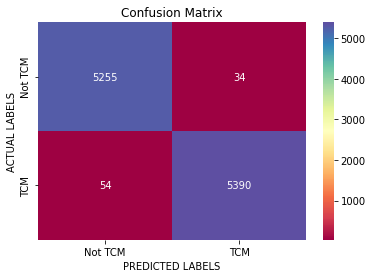

In [37]:
!pip install scikit-learn
!pip install seaborn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
test['tcm'] = test['tcm'].apply(int).tolist()
fig, ax = plt.subplots()
cm = confusion_matrix(test['tcm'],test['keras_pred'])
tn, fp, fn, tp = cm.ravel()
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral")
ax.set_ylabel('ACTUAL LABELS')
ax.set_xlabel('PREDICTED LABELS')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not TCM','TCM'])
ax.yaxis.set_ticklabels(['Not TCM','TCM'])